# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 2 - Previsão de séries temporais

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.stattools import adfuller

%matplotlib inline


In [2]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = False, category = 'binary'):
    
    global _min
    global _max
    
    
    data_values = data.values
    
    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)
        
    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)
        
    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')
    
    assert test_values.shape[0] >= (lag)
    
    _min = np.min(train_values)
    _max = np.max(train_values)
    
    if normalize:
        
        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)
        
    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))
    
    
    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))
    
    
    
    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]
        

    
    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]
        
    elif category == '1toN':
        pass
    
    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']
    
    
    new_data = np.hstack((t,new_data))
    
    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]
    
    
    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)] 
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)
    
    
    
    
    return new_train_df, new_test_df
        
    
    
    

In [3]:
raw_data = pd.read_csv('microclima2.csv')


## Visualização da Série Temporal

<AxesSubplot:>

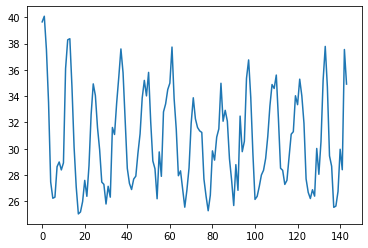

In [4]:
raw_data['value'].plot()

Text(0, 0.5, 'Temperatura')

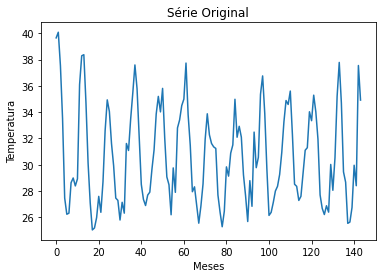

In [7]:
plt.plot(raw_data['value'])
plt.title('Série Original')
plt.xlabel('Meses')
plt.xscale()
plt.ylabel('Temperatura')

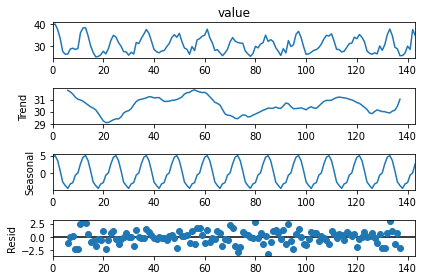

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
serie=raw_data['value']
resultado=seasonal_decompose(serie,model='additive', period=12).plot()

#claro que tem sazonalidade
#não parece haver trending. As temperaturas estao "constantes" ao longo dos mesmos meses em cada ano


In [13]:
result = adfuller(raw_data['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.340082
p-value: 0.013179
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


In [7]:
raw_data

,value,time
0,39.650538,1.0
1,40.079960,2.0
2,37.539247,3.0
3,33.522407,4.0
4,27.467921,5.0
...,...,...
139,26.751075,8.0
140,29.960556,9.0
141,28.403584,10.0
142,37.549444,11.0


In [14]:
train,test = transform_data(raw_data,lag=12,test_split = 12,normalize=True,category='binary')#atençao, moudamos o valor do lag e test_split
#Dados normalizados corretamente -> pode ser verificado pela tabela

In [15]:
train

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,1.0,0.0,0.971445,1.000000,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457
1,0.0,0.0,1.0,1.0,1.000000,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639
2,0.0,1.0,0.0,0.0,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639,0.337537
3,0.0,1.0,0.0,1.0,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639,0.337537,0.136262
4,0.0,1.0,1.0,0.0,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639,0.337537,0.136262,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1.0,0.0,0.0,0.0,0.149252,0.169844,0.286705,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248
115,1.0,0.0,0.0,1.0,0.169844,0.286705,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916
116,1.0,0.0,1.0,0.0,0.286705,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184
117,1.0,0.0,1.0,1.0,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446


In [16]:
test

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982
1,0.0,0.0,1.0,0.0,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378
2,0.0,0.0,1.0,1.0,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972
3,0.0,1.0,0.0,0.0,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441
4,0.0,1.0,0.0,1.0,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284
5,0.0,1.0,1.0,0.0,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235
6,0.0,1.0,1.0,1.0,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666
7,1.0,0.0,0.0,0.0,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666,0.113692
8,1.0,0.0,0.0,1.0,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666,0.113692,0.327107
9,1.0,0.0,1.0,0.0,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666,0.113692,0.327107,0.223576


In [17]:
train_values = train.values

x_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test.values
x_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [3]:
def create_model(hidden_neurons = [4], hidden_activation = ['relu'], output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    model = Sequential()
    model.add(Dense(hidden_neurons[0], input_dim=n_input, activation='tanh'))
    for i in range(1,len(hidden_neurons)):
        model.add(Dense(hidden_neurons[i], input_dim=hidden_neurons[i-1], activation='tanh'))
        

    model.add(Dense(n_output, activation=output_activation))
    # Compile model
    opt = Adam(lr=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error','mean_squared_error','accuracy'])
    return model

In [106]:
del model

In [107]:
model = create_model(hidden_neurons = [20], output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.05)

In [108]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 20)                360       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 21        
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [109]:
model.fit(x=x_train,y=y_train,epochs=50)

Epoch 1/50
4/4 [==============================] - 0s 1ms/step - loss: 0.7073 - mean_absolute_error: 0.7073 - mean_squared_error: 0.7041 - accuracy: 0.0034
Epoch 2/50
4/4 [==============================] - 0s 1ms/step - loss: 0.3453 - mean_absolute_error: 0.3453 - mean_squared_error: 0.1758 - accuracy: 0.0034
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2252 - mean_absolute_error: 0.2252 - mean_squared_error: 0.0792 - accuracy: 0.0086
Epoch 4/50
4/4 [==============================] - 0s 2ms/step - loss: 0.1387 - mean_absolute_error: 0.1387 - mean_squared_error: 0.0279 - accuracy: 0.0034
Epoch 5/50
4/4 [==============================] - 0s 2ms/step - loss: 0.1365 - mean_absolute_error: 0.1365 - mean_squared_error: 0.0278 - accuracy: 0.0148
Epoch 6/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1184 - mean_absolute_error: 0.1184 - mean_squared_error: 0.0200 - accuracy: 0.0034
Epoch 7/50
4/4 [==============================] - 0s 2ms/step - loss: 

Text(0.5, 1.0, 'Treino com 20 neurônios')

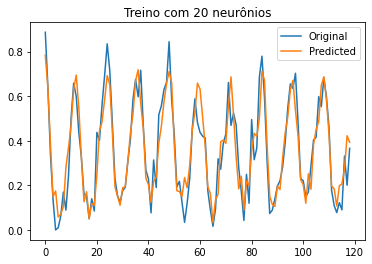

In [110]:
y_hat = model.predict(x_train)
plt.plot(y_train)
plt.plot(y_hat)
plt.legend(['Original','Predicted'])
plt.title('Treino com 20 neurônios')


### Teste 'One step-ahead'

In [111]:
y_hat = model.predict(x_test)

In [114]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

print(f'Erro RMSE = {round(np.sqrt(mse_error),3)} \nErro MAE = {round(mae_error,3)}')

Erro RMSE = 2.584 
Erro MAE = 1.938


Text(0, 0.5, 'Temperatura')

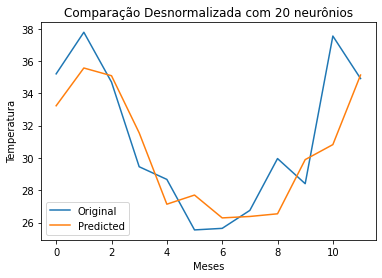

In [113]:
plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])
plt.title('Comparação Desnormalizada com 20 neurônios')
plt.xlabel('Meses')
plt.ylabel('Temperatura')

## Alteração para codificação numérica

In [23]:
raw_data = pd.read_csv('microclima2.csv')

In [24]:
train,test = transform_data(raw_data,lag=12,test_split = 12,normalize=True,category='numerical')#alteramos para codificação numérica

train_values = train.values
	
x_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test.values
x_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [5]:
train

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.090909,0.971445,1.000000,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457
1,0.181818,1.000000,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639
2,0.272727,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639,0.337537
3,0.363636,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639,0.337537,0.136262
4,0.454545,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639,0.337537,0.136262,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.636364,0.149252,0.169844,0.286705,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248
115,0.727273,0.169844,0.286705,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916
116,0.818182,0.286705,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184
117,0.909091,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446


In [6]:
test

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.000000,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982
1,0.090909,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378
2,0.181818,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972
3,0.272727,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441
4,0.363636,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284
5,0.454545,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235
6,0.545455,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666
7,0.636364,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666,0.113692
8,0.727273,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666,0.113692,0.327107
9,0.818182,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666,0.113692,0.327107,0.223576


In [25]:
del model

In [26]:
model = create_model(hidden_neurons = [20], output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.05)

model.fit(x=x_train,y=y_train,epochs=50)

Epoch 1/50
4/4 [==============================] - 0s 2ms/step - loss: 0.6071 - mean_absolute_error: 0.6071 - mean_squared_error: 0.4246 - accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 0s 7ms/step - loss: 0.2627 - mean_absolute_error: 0.2627 - mean_squared_error: 0.0935 - accuracy: 0.0034
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2213 - mean_absolute_error: 0.2213 - mean_squared_error: 0.0646 - accuracy: 0.0034
Epoch 4/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1776 - mean_absolute_error: 0.1776 - mean_squared_error: 0.0415 - accuracy: 0.0034
Epoch 5/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1403 - mean_absolute_error: 0.1403 - mean_squared_error: 0.0300 - accuracy: 0.0086
Epoch 6/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1379 - mean_absolute_error: 0.1379 - mean_squared_error: 0.0296 - accuracy: 0.0054
Epoch 7/50
4/4 [==============================] - 0s 1ms/step - lo

Text(0.5, 1.0, 'Treino com 20 neurônios')

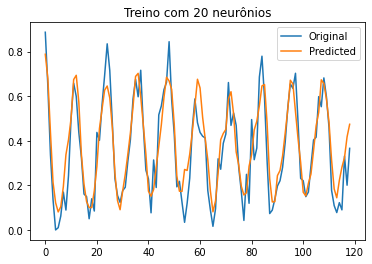

In [27]:
y_hat = model.predict(x_train)
plt.plot(y_train)
plt.plot(y_hat)
plt.legend(['Original','Predicted'])
plt.title('Treino com 20 neurônios')

In [30]:
y_hat = model.predict(x_test)
	
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

print(f'Erro RMSE = {round(np.sqrt(mse_error),3)} \nErro MAE = {round(mae_error,3)}')

Erro RMSE = 2.402 
Erro MAE = 1.777


Text(0, 0.5, 'Temperatura')

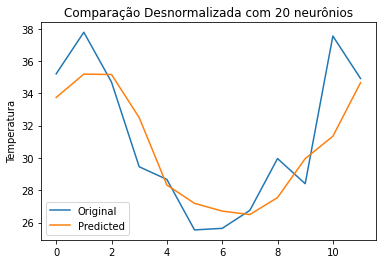

In [31]:

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])
plt.title('Comparação Desnormalizada com 20 neurônios')
plt.ylabel('Temperatura')

## Teste Multi-step 

In [135]:
raw_data = pd.read_csv('microclima2.csv')

train,test = transform_data(raw_data,lag=12,test_split = 12,normalize=True,category='numerical')# mantivemos a codificação numérica

train_values = train.values
	
x_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test.values
x_test = test_values[:,:-1]
y_test = test_values[:,-1]
            

In [136]:
del model

In [137]:
model = create_model(hidden_neurons = [20], output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.05)
model.fit(x=x_train,y=y_train,epochs=50)


Epoch 1/50
4/4 [==============================] - 0s 1ms/step - loss: 0.4264 - mean_absolute_error: 0.4264 - mean_squared_error: 0.3351 - accuracy: 0.0054
Epoch 2/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2520 - mean_absolute_error: 0.2520 - mean_squared_error: 0.0899 - accuracy: 0.0148
Epoch 3/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1412 - mean_absolute_error: 0.1412 - mean_squared_error: 0.0347 - accuracy: 0.0086
Epoch 4/50
4/4 [==============================] - 0s 2ms/step - loss: 0.1368 - mean_absolute_error: 0.1368 - mean_squared_error: 0.0284 - accuracy: 0.0148
Epoch 5/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1248 - mean_absolute_error: 0.1248 - mean_squared_error: 0.0232 - accuracy: 0.0148
Epoch 6/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1168 - mean_absolute_error: 0.1168 - mean_squared_error: 0.0203 - accuracy: 0.0086
Epoch 7/50
4/4 [==============================] - 0s 1ms/step - loss: 

In [138]:
def multi_step(model,x_serie,stepsNum):
    for i in range(stepsNum):
        y_hat=model.predict(x_serie)
        #escorregar todos os valores de x_train[1] a x_train[-1] para a esquerda
        # x_train[4]=x_train[5] ... x_train[15]=x_train[16] e x_train[16]= valor previsto
        for j in range(1,13):
            for k in range(0,x_serie.shape[0]):
                x_serie[k][j]=x_serie[k][j+1]
        x_serie[0][-1]= y_hat[0]
    return y_hat



Text(0.5, 1.0, 'Comparação da base de treino - MultiStep')

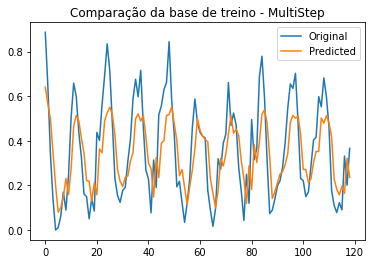

In [139]:
y_hat=multi_step(model,x_train,12)
plt.plot(y_train)
plt.plot(y_hat)
plt.legend(['Original','Predicted'])
plt.title('Comparação da base de treino - MultiStep')

In [140]:
y_hat=multi_step(model,x_test,12)

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

print(f'Erro RMSE = {round(np.sqrt(mse_error),3)} \nErro MAE = {round(mae_error,3)}')

Erro RMSE = 3.528 
Erro MAE = 2.753


In [141]:
orig_y_eval

array([35.20716846, 37.78472222, 34.69569892, 29.45425926, 28.66989247,
       25.54111111, 25.63781362, 26.75107527, 29.96055556, 28.40358423,
       37.54944444, 34.91810036])

In [142]:
orig_y_hat

array([[33.15251 ],
       [32.802563],
       [33.347244],
       [32.51298 ],
       [29.774567],
       [29.365868],
       [26.617855],
       [26.94291 ],
       [27.911919],
       [29.923042],
       [28.875557],
       [31.667719]], dtype=float32)

Text(0, 0.5, 'Temperatura')

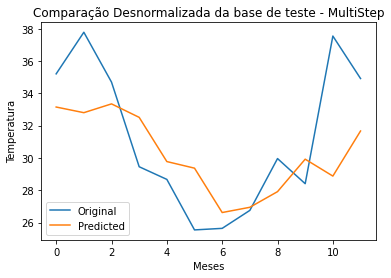

In [143]:
plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])
plt.title('Comparação Desnormalizada da base de teste - MultiStep')
plt.xlabel('Meses')
plt.ylabel('Temperatura')

## Alteração da Janela

In [234]:
raw_data = pd.read_csv('microclima2.csv')

train,test = transform_data(raw_data,lag=12,test_split = 12,normalize=True,category='binary')#alteramos para codificação binária novamente

train_values = train.values
	
x_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test.values
x_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [235]:
train

,month_0,month_1,month_2,month_3,y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,1.0,1.0,0.0,0.0,0.971445,1.000000,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149
1,0.0,0.0,0.0,1.0,1.000000,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795
2,0.0,0.0,1.0,0.0,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457
3,0.0,0.0,1.0,1.0,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639
4,0.0,1.0,0.0,0.0,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639,0.337537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1.0,0.0,0.0,0.0,0.286705,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248
117,1.0,0.0,0.0,1.0,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916
118,1.0,0.0,1.0,0.0,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184
119,1.0,0.0,1.0,1.0,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446


In [236]:
del model

In [237]:
model = create_model(hidden_neurons = [20], output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.05)

In [238]:
model.fit(x=x_train,y=y_train,epochs=50)

Epoch 1/50
4/4 [==============================] - 0s 2ms/step - loss: 0.8311 - mean_absolute_error: 0.8311 - mean_squared_error: 1.2879 - accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 0s 2ms/step - loss: 0.6233 - mean_absolute_error: 0.6233 - mean_squared_error: 0.4863 - accuracy: 0.0148
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4363 - mean_absolute_error: 0.4363 - mean_squared_error: 0.2400 - accuracy: 0.0033
Epoch 4/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2808 - mean_absolute_error: 0.2808 - mean_squared_error: 0.1074 - accuracy: 0.0054
Epoch 5/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1836 - mean_absolute_error: 0.1836 - mean_squared_error: 0.0490 - accuracy: 0.0054
Epoch 6/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1339 - mean_absolute_error: 0.1339 - mean_squared_error: 0.0273 - accuracy: 0.0033
Epoch 7/50
4/4 [==============================] - 0s 1ms/step - lo

Text(0.5, 1.0, 'Treino com janela de 10')

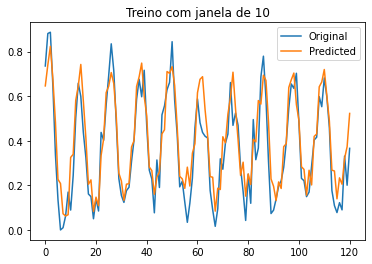

In [239]:
y_hat = model.predict(x_train)
plt.plot(y_train)
plt.plot(y_hat)
plt.legend(['Original','Predicted'])
plt.title('Treino com janela de 10')

In [240]:
y_hat = model.predict(x_test)
	
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

print(f'Erro RMSE = {round(np.sqrt(mse_error),3)} \nErro MAE = {round(mae_error,3)}')

Erro RMSE = 2.906 
Erro MAE = 2.238


Text(0.5, 1.0, 'Teste com janela de 10')

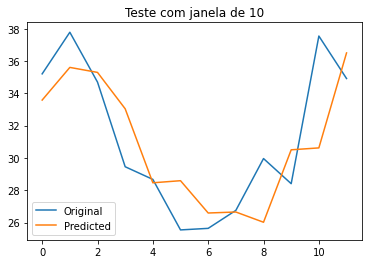

In [241]:
plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])
plt.title('Teste com janela de 10')

## Codificação 1 of N

In [242]:
raw_data = pd.read_csv('microclima2.csv')

train,test = transform_data(raw_data,lag=12,test_split = 12,normalize=True,category='binary')#alteramos para codificação binária novamente

train_values = train.values
	
x_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test.values
x_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [243]:
raw_data['time'][0]=0b0001
raw_data

,value,time
0,39.650538,1.0
1,40.079960,2.0
2,37.539247,3.0
3,33.522407,4.0
4,27.467921,5.0
...,...,...
139,26.751075,8.0
140,29.960556,9.0
141,28.403584,10.0
142,37.549444,11.0


In [244]:
del model

In [245]:
model = create_model(hidden_neurons = [20], output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.05)

In [246]:
model.fit(x=x_train,y=y_train,epochs=50)

Epoch 1/50
4/4 [==============================] - 0s 1ms/step - loss: 0.8460 - mean_absolute_error: 0.8460 - mean_squared_error: 0.9526 - accuracy: 0.0148
Epoch 2/50
4/4 [==============================] - 0s 1ms/step - loss: 0.4904 - mean_absolute_error: 0.4904 - mean_squared_error: 0.3258 - accuracy: 0.0054
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2408 - mean_absolute_error: 0.2408 - mean_squared_error: 0.0800 - accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1828 - mean_absolute_error: 0.1828 - mean_squared_error: 0.0512 - accuracy: 0.0148
Epoch 5/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1551 - mean_absolute_error: 0.1551 - mean_squared_error: 0.0361 - accuracy: 0.0148
Epoch 6/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1414 - mean_absolute_error: 0.1414 - mean_squared_error: 0.0281 - accuracy: 0.0148
Epoch 7/50
4/4 [==============================] - 0s 1ms/step - lo

In [247]:
y_hat=model.predict(x_test)
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

print(f'Erro RMSE = {round(np.sqrt(mse_error),3)} \nErro MAE = {round(mae_error,3)}')

Erro RMSE = 2.704 
Erro MAE = 1.882
